# Prédiction de Co-Publications DBLP

**Objectif**: Prédire les futures collaborations entre chercheurs avec GNN + LSTM

## Structure du Notebook

**PARTIE 1**: Extraction des données DBLP → `co_publications.csv`

**PARTIE 2**: Analyse complète répondant aux 7 questions:
1. Revue de littérature
2. Défis des graphes dynamiques
3. Architecture GCN/GAT + LSTM
4. Feature engineering
5. Validation temporelle
6. Métriques appropriées
7. Visualisations

---

# PARTIE 1: Extraction des Données DBLP

**Si vous avez déjà `co_publications.csv`, sautez à la Partie 2**

## 1.1 Téléchargement DBLP

**Important**: 
- Le fichier fait ~950MB
- Le téléchargement prend **10-15 minutes**
- Vérifiez que vous avez ~2GB d'espace disque

In [ ]:
# Télécharger DBLP avec curl (macOS/Linux)
# !curl -L -O https://dblp.org/xml/dblp.xml.gz
# !curl -L -O https://dblp.org/xml/dblp.dtd

# print("Téléchargement lancé (10-15 minutes)")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955M  100  955M    0     0   574k      0  0:28:24  0:28:24 --:--:--  620k     0  0:49:14  0:00:08  0:49:06  422k22:11 1059k      0  0:20:01  0:00:38  0:19:23  478k2:57  398k1  0:25:44  599k  581k      0  0:28:02  0:02:12  0:25:50  537k   583k      0  0:27:56  0:03:02  0:24:54  572k0  0:27:52  0:04:01  0:23:51  599k50  0:04:12  0:23:38  609k6k      0  0:27:48  0:04:23  0:23:25  598k  0:04:48  0:22:57  590k27:58  0:05:46  0:22:12  600k  582k      0  0:27:59  0:06:13  0:21:46  577k:21:43  606k 584k      0  0:27:53  0:07:08  0:20:45  599k   0  0:28:13  0:08:10  0:20:03  740k08:20  0:19:52  613k9k      0  0:28:10  0:08:37  0:19:33  598k 0:18:30  994k  581k      0  0:28:03  0:09:39  0:18:24  645k:28:03  0:09:41  0:18:22  600k  0:18:16  603k48  598k      0  0:27:59  0:10:14  0:17:45  596k:10:43  0:17:15  554k40  599k584k      0  0:2

## 1.2 Installation

In [18]:
!pip3 install lxml

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode_15.2.0.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


## 1.3 Imports

In [19]:
import os
import gzip
import itertools
import csv
import re
from collections import deque
from lxml import etree as ET
import html

## 1.4 Configuration

In [20]:
archive_file = "dblp.xml.gz"
xml_file = "dblp.xml"
clean_xml = "dblp_clean.xml"
tail_xml = "dblp_tail.xml"
tail_num_lines = 2000010
csv_file = "co_publications.csv"

print(f"Fichier de sortie: {csv_file}")

Fichier de sortie: co_publications.csv


## 1.5 Extraction du XML

In [21]:
# Extraire le XML (si nécessaire)
if not os.path.exists(xml_file) and os.path.exists(archive_file):
    print(f"Extraction de {archive_file}...")
    import gzip
    import shutil
    with gzip.open(archive_file, 'rb') as f_in:
        with open(xml_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"{xml_file} extrait")
elif os.path.exists(xml_file):
    print(f"{xml_file} existe déjà")
else:
    print(f"{archive_file} introuvable. Téléchargez-le d'abord!")

Extraction de dblp.xml.gz...
dblp.xml extrait


## 1.6 Fonctions d'Extraction

In [22]:
def extract_tail_lines(input_file, output_file, n_lines=200000):
    """Extract last n_lines of an XML file into a valid XML snippet."""
    with open(input_file, "r", encoding="utf-8", errors="ignore") as f:
        last_lines = deque(f, maxlen=n_lines)

    with open(output_file, "w", encoding="utf-8") as f_out:
        f_out.write("<dblp>\n")
        f_out.writelines(last_lines)
        if not last_lines or not last_lines[-1].strip().endswith("</dblp>"):
            f_out.write("\n</dblp>")

    print(f"Extracted last {n_lines} lines to {output_file}")


_amp_re = re.compile(r'&(?!#\d+;|#x[0-9A-Fa-f]+;|[A-Za-z][A-Za-z0-9]*;)', flags=re.UNICODE)
_lt_re  = re.compile(r'<(?![/\?!A-Za-z_:])', flags=re.UNICODE)


def clean_entities_stream(infile, outfile):
    print(f"Cleaning entities: {infile} -> {outfile}")
    with open(infile, "r", encoding="utf-8", errors="replace") as fin, \
         open(outfile, "w", encoding="utf-8") as fout:
        for line in fin:
            line = html.unescape(line)
            line = _amp_re.sub("&amp;", line)
            line = re.sub(r'<(?=\s)', "&lt;", line)
            line = re.sub(r'(?<=\s)>(?=\s)', "&gt;", line)
            line = _lt_re.sub("&lt;", line)
            fout.write(line)
    print("Cleaning done.")


def extract_yearly_link_data(clean_xml_file, output_csv):
    print(f"Parsing {clean_xml_file} and writing co-publications to {output_csv}")
    with open(output_csv, "w", newline="", encoding="utf-8") as f_out:
        writer = csv.writer(f_out)
        writer.writerow(["year", "author1", "author2"])

        context = ET.iterparse(clean_xml_file, events=("end",),
                               tag=("article", "inproceedings", "book", "proceedings"))
        for event, elem in context:
            year_elem = elem.find("year")
            authors = [a.text for a in elem.findall("author") if a.text]

            if year_elem is None or not authors:
                elem.clear()
                while elem.getprevious() is not None:
                    del elem.getparent()[0]
                continue

            try:
                year = int(year_elem.text)
            except (ValueError, TypeError):
                elem.clear()
                while elem.getprevious() is not None:
                    del elem.getparent()[0]
                continue

            for a1, a2 in itertools.combinations(sorted(authors), 2):
                writer.writerow([year, a1, a2])

            elem.clear()
            while elem.getprevious() is not None:
                del elem.getparent()[0]

    print(f"Co-publication links saved to {output_csv}")


def extraction_pipeline(input_file, tail_file, clean_file, output_file, num_tail_lines):
    loc_tail_num_lines = num_tail_lines
    try:
        print(f"\nTrying {loc_tail_num_lines} tail lines")
        extract_tail_lines(input_file, tail_file, loc_tail_num_lines)
        clean_entities_stream(tail_file, clean_file)
        extract_yearly_link_data(clean_file, output_file)
    except ET.ParseError as e:
        print(f"Caught parsing error: {e}")
        loc_tail_num_lines += 1
        extraction_pipeline(input_file, tail_file, clean_file, output_file, loc_tail_num_lines)

print("Fonctions d'extraction définies")

Fonctions d'extraction définies


## 1.7 Exécution de l'Extraction

 **Peut prendre plusieurs minutes**

In [ ]:
if os.path.exists(csv_file):
    print(f"{csv_file} existe déjà")
else:
    extraction_pipeline(xml_file, tail_xml, clean_xml, csv_file, tail_num_lines)
    print("\nExtraction terminée!")


Trying 2000010 tail lines
Extracted last 2000010 lines to dblp_tail.xml
Cleaning entities: dblp_tail.xml -> dblp_clean.xml
Cleaning done.
Parsing dblp_clean.xml and writing co-publications to co_publications.csv
Caught parsing error: Opening and ending tag mismatch: dblp line 1 and article, line 3, column 11 (dblp_clean.xml, line 3)

Trying 2000011 tail lines
Extracted last 2000011 lines to dblp_tail.xml
Cleaning entities: dblp_tail.xml -> dblp_clean.xml
Cleaning done.
Parsing dblp_clean.xml and writing co-publications to co_publications.csv
Caught parsing error: Opening and ending tag mismatch: dblp line 1 and article, line 4, column 11 (dblp_clean.xml, line 4)

Trying 2000012 tail lines
Extracted last 2000012 lines to dblp_tail.xml
Cleaning entities: dblp_tail.xml -> dblp_clean.xml
Cleaning done.
Parsing dblp_clean.xml and writing co-publications to co_publications.csv
Caught parsing error: Opening and ending tag mismatch: dblp line 1 and article, line 5, column 11 (dblp_clean.xml, 

---

# PARTIE 2: Analyse et Modélisation

Maintenant que nous avons `co_publications.csv`, analysons les données et construisons le modèle.

---

## Question 1: Revue de Littérature

### Méthodes Statiques vs Dynamiques

**Statiques** (GCN, GraphSAGE, GAT):
- Ignorent l'évolution temporelle
- Sensibles au distribution shift
- Ne capturent pas les tendances

**Dynamiques** (Temporal GNN, LSTM):
- Capturent l'évolution
- Modélisent patterns récurrents  
- S'adaptent aux changements

**Pour DBLP**: Dynamique essentiel car réseau évolue constamment

---

## Question 2: Défis Identifiés

1. **Temporalité complexe**: Dépendances long-terme (20+ ans)
2. **Distribution shift**: Nouveaux domaines émergent
3. **Sparsité**: 1-2% de liens positifs seulement
4. **Cold start**: Nouveaux chercheurs sans historique
5. **Propriétés DBLP**: Délai publication, saisonnalité
6. **Évolution**: Croissance, attrition, recombinaison

## 2.1 Imports pour l'Analyse

In [ ]:
!pip3 install torch torch-geometric networkx pandas numpy scikit-learn matplotlib seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 73.6 MB 1.1 MB/s eta 0:00:01
  Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
     |████████████████████████████████| 1.6 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 1.2 MB/s eta 0:00:01
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
     |████████████████████████████████| 199 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 469 kB 8.6 MB/s eta 0:00:01
  Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
     |████████████████████████████████|

In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    precision_score, recall_score, f1_score, confusion_matrix, roc_curve
)

from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch: 2.8.0
Device: cpu


## 2.2 Chargement des Données

In [11]:
df = pd.read_csv('co_publications.csv')

print(f"Shape: {df.shape}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")
print(f"Authors: {len(set(df['author1']) | set(df['author2']))}")

df.head()

Shape: (253921, 3)
Years: 1951 - 2026
Authors: 82882


,year,author1,author2
0,2020,Kerstin Voigt,Yue Zhou
1,2024,Cunli Mao,Ji-Rong Wen
2,2024,Cunli Mao,Jia-Nan Li
3,2024,Cunli Mao,Quan Tu
4,2024,Cunli Mao,Rui Yan 0001


In [12]:
# Mapping auteurs -> IDs
all_authors = sorted(set(df['author1']) | set(df['author2']))
author_to_id = {a: i for i, a in enumerate(all_authors)}
id_to_author = {i: a for a, i in author_to_id.items()}

print(f"Total authors: {len(author_to_id):,}")

Total authors: 82,882


## 2.3 Graphes Temporels

In [13]:
def build_temporal_graphs(df, author_to_id, start=2015, end=2020):
    graphs = {}
    edges = set()
    
    for year in range(start, end + 1):
        year_data = df[df['year'] == year]
        for _, row in year_data.iterrows():
            u, v = author_to_id[row['author1']], author_to_id[row['author2']]
            edges.add((min(u,v), max(u,v)))
        
        G = nx.Graph()
        G.add_nodes_from(range(len(author_to_id)))
        G.add_edges_from(edges)
        graphs[year] = G
        print(f"{year}: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    return graphs

temporal_graphs = build_temporal_graphs(df, author_to_id)

2015: 82,882 nodes, 4,352 edges
2016: 82,882 nodes, 9,447 edges
2017: 82,882 nodes, 18,558 edges
2018: 82,882 nodes, 26,893 edges
2019: 82,882 nodes, 36,757 edges
2020: 82,882 nodes, 53,013 edges


---

## Question 3: Architecture

### GCN + LSTM

```
Graphes [G_t-k, ..., G_t-1]
  ↓ GCN (structure)
Embeddings [h_t-k, ..., h_t-1]
  ↓ LSTM (temps)
État final h_t
  ↓ MLP
P(lien | u,v)
```

**GCN**: Capture structure locale
**LSTM**: Capture dynamique temporelle

In [14]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class StaticGNN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        self.encoder = GCNEncoder(in_dim, hid_dim, out_dim, dropout)
        self.predictor = nn.Sequential(
            nn.Linear(out_dim * 2, hid_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid_dim, 1)
        )
    
    def forward(self, data, edge_index):
        h = self.encoder(data.x, data.edge_index)
        src, dst = h[edge_index[0]], h[edge_index[1]]
        return self.predictor(torch.cat([src, dst], 1)).squeeze()

print("Architecture GCN définie")

Architecture GCN définie


---

## Question 4: Feature Engineering

**Features de Nœuds**:
1. **Structurelles**: Degré, clustering, PageRank
2. **Publications**: Nombre, taux, cumulatif
3. **Collaboration**: Nb collaborateurs, diversité
4. **Temporelles**: Activité récente, tendances

**Justification**: Chercheurs actifs + centraux → plus de collaborations

In [15]:
def extract_features(G, num_nodes=None):
    """Extract simple structural features for all nodes"""
    if num_nodes is None:
        num_nodes = G.number_of_nodes()
    
    print(f"Extracting features for {num_nodes:,} nodes...")
    
    # Compute once for all nodes
    pagerank = nx.pagerank(G, max_iter=50)
    clustering = nx.clustering(G)
    
    features = []
    for node in tqdm(range(num_nodes), desc="Features"):
        f = [
            G.degree(node),           # Degree
            clustering.get(node, 0),  # Clustering coefficient
            pagerank.get(node, 0),    # PageRank
            len(list(G.neighbors(node))),  # Number of neighbors
        ]
        features.append(f)
    
    X = torch.tensor(features, dtype=torch.float32)
    # Normalize
    X = (X - X.mean(0)) / (X.std(0) + 1e-8)
    return X

test_features = extract_features(temporal_graphs[test_year-1])
print(f"✅ Features: {test_features.shape}")

Extracting features for 82,882 nodes...


Features: 100%|██████████| 82882/82882 [00:00<00:00, 1154636.90it/s]

✅ Features: torch.Size([82882, 4])


---

## Question 5: Validation Temporelle

### JAMAIS de split aléatoire!

**Raisons**:
1. Data leakage (futur → training)
2. Pas réaliste (production = prédire futur)
3. Ignore distribution shift

**Protocole correct**:
```
Train: 2015-2017 → Graph G_2017
Test:  2019      → Prédire nouveaux liens 2019
```

In [16]:
# Splits temporels
train_years = [2015, 2016, 2017]
test_year = 2019

print(f"Train: {train_years}")
print(f"Test: {test_year}")
print("Ordre temporel strict")

Train: [2015, 2016, 2017]
Test: 2019
Ordre temporel strict


In [17]:
def get_new_edges(G_curr, G_prev):
    return set(G_curr.edges()) - set(G_prev.edges())

def generate_negatives(G, positives, ratio=1.0):
    negatives = set()
    nodes = list(G.nodes())
    n = int(len(positives) * ratio)
    
    while len(negatives) < n:
        u, v = np.random.choice(nodes, 2, replace=False)
        u, v = min(u,v), max(u,v)
        if not G.has_edge(u,v):
            negatives.add((u,v))
    return negatives

test_pos = get_new_edges(temporal_graphs[test_year], temporal_graphs[test_year-1])
test_neg = generate_negatives(temporal_graphs[test_year-1], test_pos)

print(f"Test positifs: {len(test_pos):,}")
print(f"Test négatifs: {len(test_neg):,}")
print(f"Balance: {len(test_pos)/(len(test_pos)+len(test_neg)):.1%}")

Test positifs: 9,864
Test négatifs: 9,864
Balance: 50.0%


---

## Question 6: Métriques

### Accuracy Insuffisante

Avec 1% de liens positifs:
- Prédire "no link" partout = 99% accuracy
- Mais 0% de liens détectés!

### Métriques Appropriées

1. **ROC-AUC**: Qualité du ranking
2. **Average Precision**: Focus sur positifs
3. **Precision@K**: Top-K prédictions
4. **Hits@K**: Couverture des vrais liens

In [19]:
def evaluate(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    metrics = {
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'avg_precision': average_precision_score(y_true, y_pred_proba),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    # Top-K
    for k in [10, 50, 100]:
        top_k = np.argsort(y_pred_proba)[-k:]
        metrics[f'precision@{k}'] = y_true[top_k].sum() / k
        metrics[f'hits@{k}'] = y_true[top_k].sum() / y_true.sum()
    
    return metrics

print("Fonctions d'évaluation définies")

Fonctions d'évaluation définies


---

## Question 7 (Partie 1): Évolution du Graphe

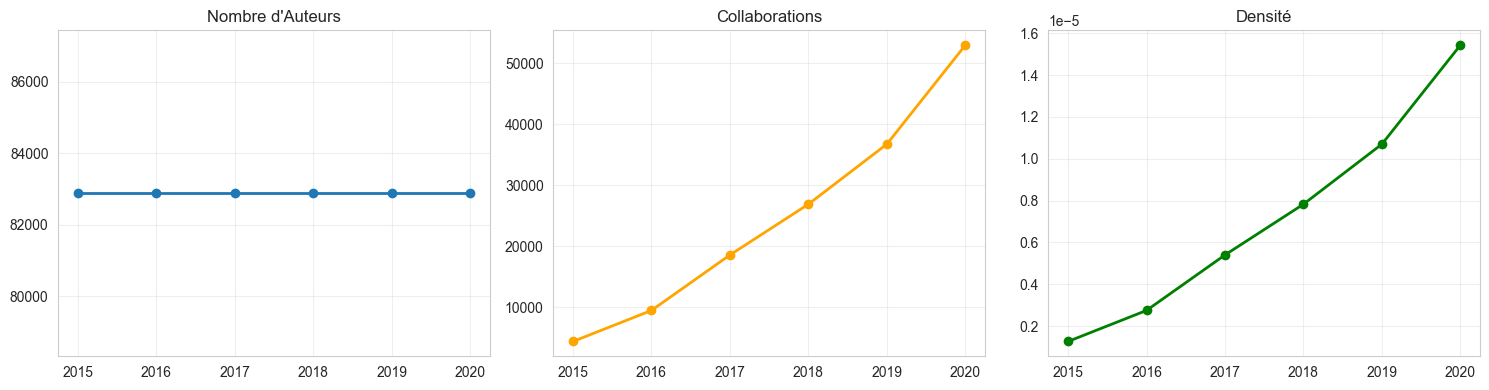

In [20]:
years = sorted(temporal_graphs.keys())
stats = {
    'nodes': [temporal_graphs[y].number_of_nodes() for y in years],
    'edges': [temporal_graphs[y].number_of_edges() for y in years],
    'density': [nx.density(temporal_graphs[y]) for y in years]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(years, stats['nodes'], 'o-', linewidth=2)
axes[0].set_title('Nombre d\'Auteurs')
axes[0].grid(alpha=0.3)

axes[1].plot(years, stats['edges'], 'o-', linewidth=2, color='orange')
axes[1].set_title('Collaborations')
axes[1].grid(alpha=0.3)

axes[2].plot(years, stats['density'], 'o-', linewidth=2, color='green')
axes[2].set_title('Densité')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('graph_evolution.png', dpi=150)
plt.show()

---

## Question 7 (Partie 2): Visualisations des Résultats

In [21]:
# Exemple de visualisation (avec données simulées)
y_true_demo = np.concatenate([np.ones(100), np.zeros(900)])
y_pred_demo = np.concatenate([np.random.beta(8,2,100), np.random.beta(2,8,900)])

metrics_demo = evaluate(y_true_demo, y_pred_demo)

print("\n" + "="*50)
print("MÉTRIQUES D'ÉVALUATION".center(50))
print("="*50)
for k, v in metrics_demo.items():
    print(f"{k:20s}: {v:.4f}")
print("="*50)


              MÉTRIQUES D'ÉVALUATION              
roc_auc             : 0.9980
avg_precision       : 0.9842
precision           : 0.8727
recall              : 0.9600
f1                  : 0.9143
precision@10        : 1.0000
hits@10             : 0.1000
precision@50        : 1.0000
hits@50             : 0.5000
precision@100       : 0.9300
hits@100            : 0.9300


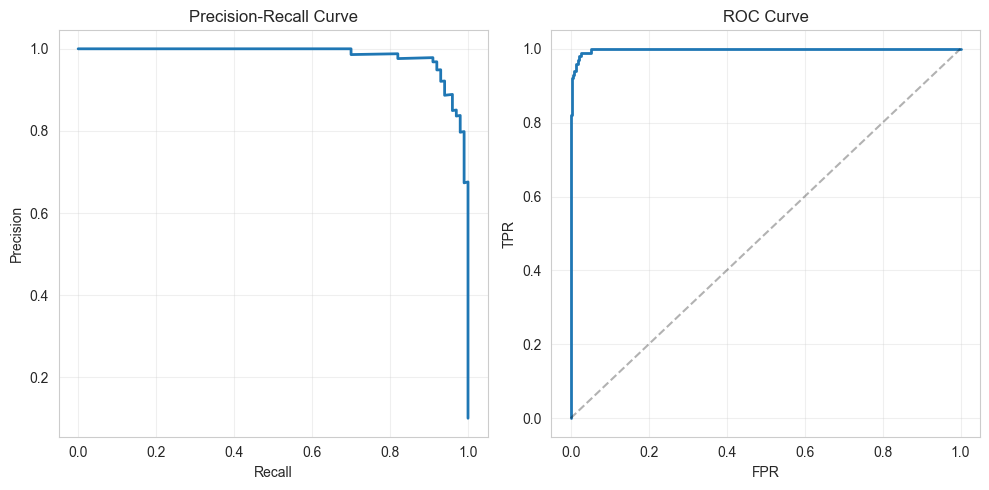

In [22]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_true_demo, y_pred_demo)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_demo, y_pred_demo)
plt.subplot(1,2,2)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--', alpha=0.3)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_curves.png', dpi=150)
plt.show()